In [145]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.base import clone

In [146]:
credits = pd.read_csv('../../data/original_data/credits.csv')
titles = pd.read_csv('../../data/original_data/titles.csv')

In [147]:
credits.head()

,person_id,id,name,character,role
0,60017,tm155702,Judy Garland,Dorothy Gale,ACTOR
1,53496,tm155702,Ray Bolger,Hunk / Scarecrow,ACTOR
2,79549,tm155702,Jack Haley,Hickory / Tin Man,ACTOR
3,79548,tm155702,Bert Lahr,Zeke / Cowardly Lion,ACTOR
4,60995,tm155702,Margaret Hamilton,Elmira Gulch / Wicked Witch of the West,ACTOR


In [148]:
titles.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,tm155702,The Wizard of Oz,MOVIE,Young Dorothy finds herself in a magical world...,1939,G,102,"['fantasy', 'family']",['US'],NaN,tt0032138,8.1,389774.0,41.442,7.6
1,tm83648,Citizen Kane,MOVIE,"Newspaper magnate, Charles Foster Kane is take...",1941,PG,119,['drama'],['US'],NaN,tt0033467,8.3,433804.0,14.383,8.0
2,tm77588,Casablanca,MOVIE,"In Casablanca, Morocco in December 1941, a cyn...",1942,PG,102,"['drama', 'romance', 'war']",['US'],NaN,tt0034583,8.5,558849.0,20.087,8.2
3,tm82363,The Big Sleep,MOVIE,Private Investigator Philip Marlowe is hired b...,1946,NaN,116,"['thriller', 'crime']",['US'],NaN,tt0038355,7.9,84494.0,12.911,7.7
4,tm84701,The Maltese Falcon,MOVIE,A private detective takes on a case that invol...,1941,NaN,100,"['thriller', 'romance', 'crime']",['US'],NaN,tt0033870,8.0,156603.0,12.788,7.8


In [149]:
credits.shape, titles.shape

((66393, 5), (3294, 15))

# Join CSV's

In [150]:
master_df = pd.merge(credits, titles, how='left', on='id')

In [151]:
master_df.isna().sum()

person_id                   0
id                          0
name                        0
character                4505
role                        0
title                       0
type                        0
description                11
release_year                0
age_certification       15693
runtime                     0
genres                      0
production_countries        0
seasons                 61706
imdb_id                  2940
imdb_score               3104
imdb_votes               3169
tmdb_popularity             0
tmdb_score                869
dtype: int64

# Fix Missing Values

In [152]:
master_df[master_df['seasons'].isna()]['type'].value_counts()

MOVIE    61706
Name: type, dtype: int64

## character                4505

In [153]:
master_df['character'].value_counts()               

Self                      1812
Himself                    614
Self (archive footage)     395
Herself                    289
Dancer                     272
                          ... 
Dr. Payson                   1
Eva Marie                    1
Saudi                        1
Lisha                        1
Oficial Jaramillo            1
Name: character, Length: 41689, dtype: int64

In [154]:
master_df[master_df['character'].isna()]['role'].value_counts()

DIRECTOR    2774
ACTOR       1731
Name: role, dtype: int64

> It appears that the a large sum of the missing values for character is Director while actor I will explore more

In [155]:
master_df[master_df['character'].isna()][master_df['role'] == 'ACTOR']

/var/folders/tc/ghq6k32j7ks17t5xtkhk3sl80000gn/T/ipykernel_17071/1210722993.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  master_df[master_df['character'].isna()][master_df['role'] == 'ACTOR']


,person_id,id,name,character,role,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
327,13410,tm82363,Suzanne Ridgeway,NaN,ACTOR,The Big Sleep,MOVIE,Private Investigator Philip Marlowe is hired b...,1946,NaN,116,"['thriller', 'crime']",['US'],NaN,tt0038355,7.9,84494.0,12.911,7.7
569,2357267,tm81960,Sally Cleaves,NaN,ACTOR,The Philadelphia Story,MOVIE,When a rich woman's ex-husband and a tabloid-t...,1940,NaN,113,"['romance', 'comedy']",['US'],NaN,tt0032904,7.9,68337.0,11.587,7.7
570,207582,tm81960,Oliver Cross,NaN,ACTOR,The Philadelphia Story,MOVIE,When a rich woman's ex-husband and a tabloid-t...,1940,NaN,113,"['romance', 'comedy']",['US'],NaN,tt0032904,7.9,68337.0,11.587,7.7
571,49075,tm81960,Dick Gordon,NaN,ACTOR,The Philadelphia Story,MOVIE,When a rich woman's ex-husband and a tabloid-t...,1940,NaN,113,"['romance', 'comedy']",['US'],NaN,tt0032904,7.9,68337.0,11.587,7.7
572,33003,tm81960,Sam Harris,NaN,ACTOR,The Philadelphia Story,MOVIE,When a rich woman's ex-husband and a tabloid-t...,1940,NaN,113,"['romance', 'comedy']",['US'],NaN,tt0032904,7.9,68337.0,11.587,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66336,675835,tm1066107,Patrick McGilligan,NaN,ACTOR,Oscar Micheaux - The Superhero of Black Filmma...,MOVIE,A look at the extraordinary achievements and c...,2021,NaN,80,['documentation'],['IT'],NaN,tt14983798,6.9,88.0,1.002,NaN
66337,141091,tm1066107,Kevin Willmott,NaN,ACTOR,Oscar Micheaux - The Superhero of Black Filmma...,MOVIE,A look at the extraordinary achievements and c...,2021,NaN,80,['documentation'],['IT'],NaN,tt14983798,6.9,88.0,1.002,NaN
66338,16733,tm1066107,John Singleton,NaN,ACTOR,Oscar Micheaux - The Superhero of Black Filmma...,MOVIE,A look at the extraordinary achievements and c...,2021,NaN,80,['documentation'],['IT'],NaN,tt14983798,6.9,88.0,1.002,NaN
66339,183165,tm1066107,Haskell Wexler,NaN,ACTOR,Oscar Micheaux - The Superhero of Black Filmma...,MOVIE,A look at the extraordinary achievements and c...,2021,NaN,80,['documentation'],['IT'],NaN,tt14983798,6.9,88.0,1.002,NaN


In [156]:
master_df.dropna(subset ='character', inplace=True)
master_df['character'].value_counts()

Self                      1812
Himself                    614
Self (archive footage)     395
Herself                    289
Dancer                     272
                          ... 
Dr. Payson                   1
Eva Marie                    1
Saudi                        1
Lisha                        1
Oficial Jaramillo            1
Name: character, Length: 41689, dtype: int64

## description                11

In [157]:
master_df[master_df['description'].isna()]

,person_id,id,name,character,role,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
56861,35820,tm840302,Luigi Sciamanna,Raul (foley artist),ACTOR,Lucy,MOVIE,NaN,2018,NaN,15,['romance'],"['VE', 'US']",NaN,NaN,NaN,NaN,0.683,5.0
66329,2124029,tm1142907,Natti Natasha,Self,ACTOR,Natti Natasha,MOVIE,NaN,2021,PG-13,65,['music'],['US'],NaN,NaN,NaN,NaN,0.817,NaN
66356,1197742,tm1128651,Farruko,Farruko,ACTOR,Farruko Live On Max,MOVIE,NaN,2021,NaN,75,['music'],[],NaN,NaN,NaN,NaN,0.725,NaN


> Being that the missing description is for newer movies im going to fill them with empty strings.

In [158]:
master_df['description'] = master_df['description'].fillna('', axis='index')

## age_certification       15693

In [159]:
master_df['age_certification'].isna().sum()

13545

In [160]:
master_df[master_df['age_certification'].isna()]['type'].value_counts()

MOVIE    13126
SHOW       419
Name: type, dtype: int64

In [161]:
master_df[master_df['age_certification'].isna()]['release_year'].value_counts()

2020    897
2019    616
2021    598
1941    405
2015    353
       ... 
1981      5
1904      4
1906      2
1903      1
1901      1
Name: release_year, Length: 109, dtype: int64

> I would love to incorporate this feature but being the spread of missing age_certification would be to hard to predict with a imputer and most likely screw my future models preformance.

## seasons                 61706

In [162]:
master_df[master_df['seasons'].isna()]['type'].value_counts()

MOVIE    57653
Name: type, dtype: int64

> being that the missing observations are movies I plan on filling them in with 0.5 or 1

In [163]:
master_df['seasons'] = master_df['seasons'].fillna(0.5, axis='index')

## imdb_id                  2940

> Being that the imdb id isnt necessary I will drop this column

## imdb_score               3104, imdb_votes               3169, mdb_score                869

In [164]:
master_df[master_df['imdb_score'].isna()]

,person_id,id,name,character,role,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
1949,120559,tm127045,Georges Méliès,Professor Barbenfouillis / The Moon,ACTOR,A Trip to the Moon,MOVIE,Professor Barbenfouillis and five of his colle...,1902,NaN,15,"['scifi', 'fantasy', 'european']",['FR'],0.5,NaN,NaN,NaN,13.032,8.0
1950,120561,tm127045,Bleuette Bernon,Lady in the Moon (uncredited),ACTOR,A Trip to the Moon,MOVIE,Professor Barbenfouillis and five of his colle...,1902,NaN,15,"['scifi', 'fantasy', 'european']",['FR'],0.5,NaN,NaN,NaN,13.032,8.0
1951,120563,tm127045,Victor André,Astronomer (uncredited),ACTOR,A Trip to the Moon,MOVIE,Professor Barbenfouillis and five of his colle...,1902,NaN,15,"['scifi', 'fantasy', 'european']",['FR'],0.5,NaN,NaN,NaN,13.032,8.0
1952,120560,tm127045,Henri Delannoy,Captain of the Rocket (uncredited),ACTOR,A Trip to the Moon,MOVIE,Professor Barbenfouillis and five of his colle...,1902,NaN,15,"['scifi', 'fantasy', 'european']",['FR'],0.5,NaN,NaN,NaN,13.032,8.0
1953,120562,tm127045,Brunnet,Astronomer (uncredited),ACTOR,A Trip to the Moon,MOVIE,Professor Barbenfouillis and five of his colle...,1902,NaN,15,"['scifi', 'fantasy', 'european']",['FR'],0.5,NaN,NaN,NaN,13.032,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66372,2012331,tm1082718,Elvis Martinez,Self,ACTOR,Romeo Santos: Utopia Live from MetLife Stadium,MOVIE,In this Concert he focuses on the star and mos...,2021,NaN,103,"['romance', 'music']",['PR'],0.5,NaN,NaN,NaN,8.425,8.1
66373,2012486,tm1082718,Kiko Rodriguez,Self,ACTOR,Romeo Santos: Utopia Live from MetLife Stadium,MOVIE,In this Concert he focuses on the star and mos...,2021,NaN,103,"['romance', 'music']",['PR'],0.5,NaN,NaN,NaN,8.425,8.1
66374,419156,tm1082718,Luis Vargas,Self,ACTOR,Romeo Santos: Utopia Live from MetLife Stadium,MOVIE,In this Concert he focuses on the star and mos...,2021,NaN,103,"['romance', 'music']",['PR'],0.5,NaN,NaN,NaN,8.425,8.1
66375,2012505,tm1082718,Monchy & Alexandra,Self,ACTOR,Romeo Santos: Utopia Live from MetLife Stadium,MOVIE,In this Concert he focuses on the star and mos...,2021,NaN,103,"['romance', 'music']",['PR'],0.5,NaN,NaN,NaN,8.425,8.1


In [165]:
imputer = KNNImputer(n_neighbors=5)
master_df[list(master_df.select_dtypes(include=[np.number]).columns.values)] = imputer.fit_transform(master_df[list(master_df.select_dtypes(include=[np.number]).columns.values)])

In [166]:
master_df.isna().sum()

person_id                   0
id                          0
name                        0
character                   0
role                        0
title                       0
type                        0
description                 0
release_year                0
age_certification       13545
runtime                     0
genres                      0
production_countries        0
seasons                     0
imdb_id                  2493
imdb_score                  0
imdb_votes                  0
tmdb_popularity             0
tmdb_score                  0
dtype: int64

# Features you need to drop:
- imdb_id
- id
- age_certification
- name = its repetative with person id

In [167]:
master_df.drop(columns=['imdb_id', 'id', 'age_certification', 'name'], inplace=True)

In [168]:
master_df.isna().sum()

person_id               0
character               0
role                    0
title                   0
type                    0
description             0
release_year            0
runtime                 0
genres                  0
production_countries    0
seasons                 0
imdb_score              0
imdb_votes              0
tmdb_popularity         0
tmdb_score              0
dtype: int64

# Drop Unecessary Columns

In [169]:
master_df.drop(columns=['character', 'seasons'], inplace=True)
master_df.to_csv('../../data/cleaned_data/cleaned_HBO_data.csv', index=False)


# Fix list columns

In [170]:
master_df = pd.read_csv('../../data/cleaned_data/cleaned_HBO_data.csv', converters={'genres': pd.eval, 'production_countries': pd.eval})

In [172]:
master_df['genres'] = master_df['genres'].str.join(' ')
master_df['production_countries'] = master_df['production_countries'].str.join(' ')

In [173]:
master_df['description'].fillna('', inplace=True)

In [174]:
master_df.to_csv('../../data/model_data/model_ready_data.csv', index=False)

# EDA Visuals

In [57]:
# - mean and std popularity score
print(f"mean: {master_df['tmdb_popularity'].mean()} std: {master_df['tmdb_popularity'].std()} max: {master_df['tmdb_popularity'].max()} min: {master_df['tmdb_popularity'].min()}")

mean: 37.666505300058176 std: 170.09954214227824 max: 4447.894 min: 0.050393


In [56]:
print(f"mean: {master_df['runtime'].mean()} std: {master_df['runtime'].std()} max: {master_df['runtime'].max()} min: {master_df['runtime'].min()}")

mean: 105.88180261116857 std: 32.773043250863466 max: 255.0 min: 2.0


<AxesSubplot:xlabel='type'>

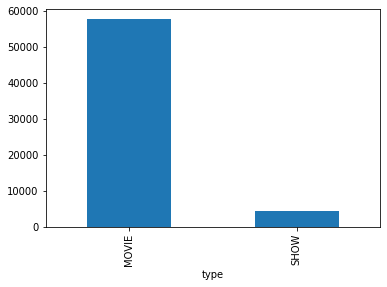

In [40]:
# - make up of all hbo TV Shows/Movies
master_df.groupby(['type'])['type'].count().plot.bar()

<AxesSubplot:xlabel='seasons'>

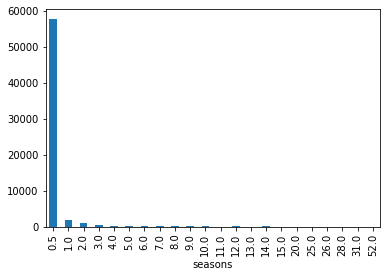

In [39]:
# - makeup of observations by season
master_df.groupby(['seasons'])['seasons'].count().plot.bar()

<AxesSubplot:xlabel='release_year'>

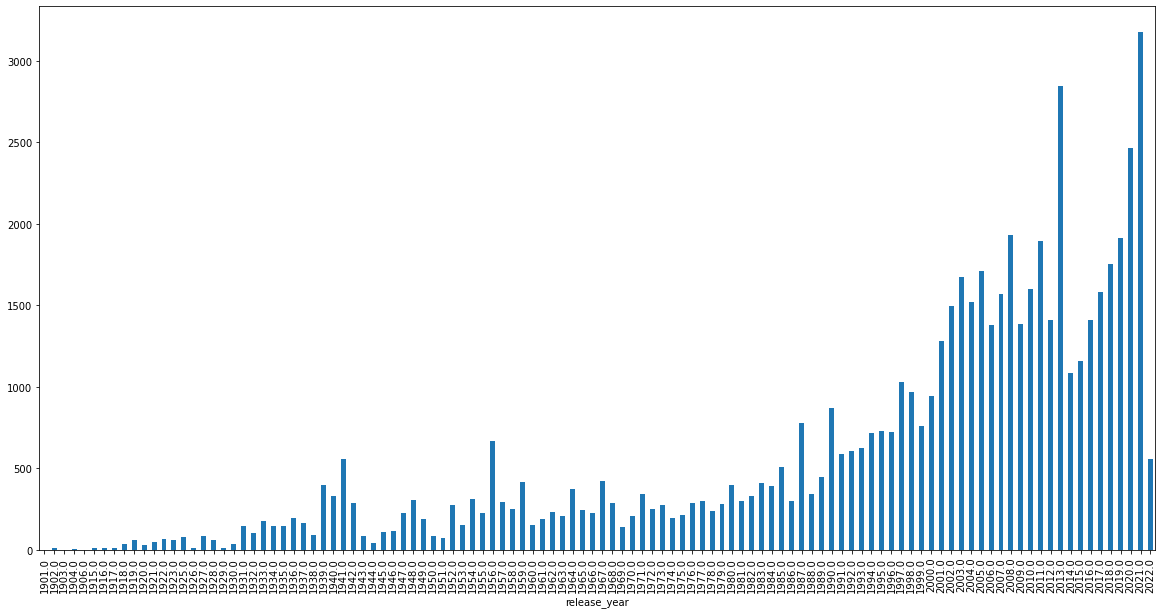

In [54]:
# - Count of hbo movies by year
master_df.groupby(['release_year'])['release_year'].count().plot.bar(figsize=(20,10))